# Graph Convolutional Network

## 1) Importing data

In [1]:
import json

import torch
from collections import defaultdict
from torch_geometric.data import HeteroData

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_graphs_as_heterodata(json_path):
    def _to_tensor_2d_float(rows):
        if not rows: return torch.empty((0, 0), dtype=torch.float32)
        dim = len(rows[0])
        for r in rows:
            if len(r) != dim: raise ValueError("Inconsistent feature length")
        return torch.tensor(rows, dtype=torch.float32)

    def _edge_index_tensor(src, dst):
        if not src: return torch.empty((2, 0), dtype=torch.long)
        return torch.tensor([src, dst], dtype=torch.long)


    with open(json_path, 'r') as f:
        data = json.load(f)

    graphs = data['graphs']
    hetero_graphs = []

    for graph in graphs:
        hetero_data = HeteroData()

        tx_feats, tx_labels = [], []
        outpoint_feats, outpoint_labels = [], []
        node_type_map = {}  # str_node_id → (local_idx, type)

        tx_i = outpoint_i = 0
        for n in graph["nodes"]:
            ntype = n["id"].split(":")[0]
            nid   = n["id"]
            feats = [float(x) for key, x in (n.get("features").items() or {})]
            raw_label = n.get("label", None)
            if raw_label is None:
                label = -1
            else:
                label = int(raw_label)

            if ntype == "tx":
                node_type_map[nid] = (tx_i, "tx")
                tx_feats.append(feats); tx_labels.append(label); tx_i += 1
            else:
                node_type_map[nid] = (outpoint_i, "outpoint")
                outpoint_feats.append(feats); outpoint_labels.append(label); outpoint_i += 1

        hetero_data["tx"].x = _to_tensor_2d_float(tx_feats)
        hetero_data["tx"].y = torch.tensor(tx_labels, dtype=torch.long) if tx_labels else torch.empty((0,), dtype=torch.long)

        hetero_data["outpoint"].x = _to_tensor_2d_float(outpoint_feats)
        hetero_data["outpoint"].x = _to_tensor_2d_float(outpoint_feats)

        # Labels als Tensor
        if outpoint_labels:
            y_out = torch.tensor(outpoint_labels, dtype=torch.long)
            # Maske: nur Knoten mit Label != -1 sind Targets
            is_target = torch.tensor([lbl != -1 for lbl in outpoint_labels], dtype=torch.bool)
        else:
            y_out = torch.empty((0,), dtype=torch.long)
            is_target = torch.zeros(0, dtype=torch.bool)

        hetero_data["outpoint"].y = y_out
        hetero_data["outpoint"].is_target = is_target

        edge_store = defaultdict(lambda: {"src": [], "dst": []})
        for e in graph.get("edges", []):
            s_id = e["source"]
            t_id = e["target"]

            if s_id not in node_type_map or t_id not in node_type_map:
                continue

            s_idx, s_type = node_type_map[s_id]
            t_idx, t_type = node_type_map[t_id]

            if(s_type, t_type) == ("outpoint", "tx"):
                rel = ("outpoint", "to", "tx")
            elif (s_type, t_type) == ("tx", "outpoint"):
                rel = ("tx", "to", "outpoint")
            else:
                continue

            edge_store[rel]["src"].append(s_idx)
            edge_store[rel]["dst"].append(t_idx)

        # Reverse Edges
        new_edges = defaultdict(lambda: {"src": [], "dst": []})
        for (src_t, rel_name, dst_t), payload in list(edge_store.items()):
            rev_rel = (dst_t, rel_name + "_rev_", src_t)
            new_edges[rev_rel]["src"].extend(payload["dst"])
            new_edges[rev_rel]["dst"].extend(payload["src"])

        for rel, payload in new_edges.items():
            edge_store[rel]["src"].extend(payload["src"])
            edge_store[rel]["dst"].extend(payload["dst"])

        for rel, payload in edge_store.items():
            hetero_data[rel].edge_index = _edge_index_tensor(payload["src"], payload["dst"])

        hetero_graphs.append(hetero_data)

    return hetero_graphs

In [6]:
import json
import torch
from collections import defaultdict
from torch_geometric.data import HeteroData

def load_graphs_as_heterodata_ndjson(ndjson_path):
    def _to_tensor_2d_float(rows):
        if not rows:
            return torch.empty((0, 0), dtype=torch.float32)
        dim = len(rows[0])
        for r in rows:
            if len(r) != dim:
                raise ValueError("Inconsistent feature length in node features")
        return torch.tensor(rows, dtype=torch.float32)

    def _edge_index_tensor(src, dst):
        if not src:
            return torch.empty((2, 0), dtype=torch.long)
        return torch.tensor([src, dst], dtype=torch.long)

    hetero_graphs = []

    with open(ndjson_path, "r") as f:
        for line_num, line in enumerate(f, start=1):
            print(line_num)
            line = line.strip()
            if not line:
                continue

            graph = json.loads(line)

            hetero_data = HeteroData()

            # ---------- Prepare storage ----------
            tx_feats, tx_labels = [], []
            out_feats, out_labels = [], []
            node_type_map = {}

            tx_i = out_i = 0

            # ---------- Nodes ----------
            for n in graph["nodes"]:
                nid = n["id"]
                ntype = nid.split(":")[0]  # "tx" oder "outpoint"

                feats = [float(x) for x in (n.get("features") or {}).values()]
                raw_label = n.get("label", None)
                if raw_label is None:
                    label = -1
                else:
                    label = int(raw_label)

                if ntype == "tx":
                    node_type_map[nid] = (tx_i, "tx")
                    tx_feats.append(feats)
                    tx_labels.append(label)
                    tx_i += 1
                else:
                    node_type_map[nid] = (out_i, "outpoint")
                    out_feats.append(feats)
                    out_labels.append(label)
                    out_i += 1

            # Create node tensors
            hetero_data["tx"].x = _to_tensor_2d_float(tx_feats)
            hetero_data["tx"].y = torch.tensor(tx_labels, dtype=torch.long) if tx_labels else torch.empty((0,), dtype=torch.long)

            hetero_data["outpoint"].x = _to_tensor_2d_float(out_feats)

            if out_labels:
                y_out = torch.tensor(out_labels, dtype=torch.long)
                mask = torch.tensor([lbl != -1 for lbl in out_labels], dtype=torch.bool)
            else:
                y_out = torch.empty((0,), dtype=torch.long)
                mask = torch.zeros(0, dtype=torch.bool)

            hetero_data["outpoint"].y = y_out
            hetero_data["outpoint"].is_target = mask

            # ---------- Edges ----------
            edge_store = defaultdict(lambda: {"src": [], "dst": []})

            for e in graph["edges"]:
                s_id = e["source"]
                t_id = e["target"]

                if s_id not in node_type_map or t_id not in node_type_map:
                    continue

                s_idx, s_type = node_type_map[s_id]
                t_idx, t_type = node_type_map[t_id]

                if (s_type, t_type) == ("outpoint", "tx"):
                    rel = ("outpoint", "to", "tx")
                elif (s_type, t_type) == ("tx", "outpoint"):
                    rel = ("tx", "to", "outpoint")
                else:
                    continue

                edge_store[rel]["src"].append(s_idx)
                edge_store[rel]["dst"].append(t_idx)

            # Add reverse edges
            for (src_t, rel_name, dst_t), payload in list(edge_store.items()):
                rev_rel = (dst_t, rel_name + "_rev_", src_t)
                edge_store[rev_rel]["src"].extend(payload["dst"])
                edge_store[rev_rel]["dst"].extend(payload["src"])

            # Convert edges to tensors
            for rel, payload in edge_store.items():
                hetero_data[rel].edge_index = _edge_index_tensor(payload["src"], payload["dst"])

            hetero_graphs.append(hetero_data)

    return hetero_graphs

In [8]:
import os
eval_path = os.path.join(os.getcwd(), 'graph_export.ndjson')
eval_data = load_graphs_as_heterodata_ndjson(eval_path)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
path = os.path.join(os.getcwd(), '.ndjson')
data = load_graphs_as_heterodata(path)

In [9]:
eval_data = data

In [15]:
g = data[0]
g

HeteroData(
  tx={
    x=[5, 28],
    y=[5],
  },
  outpoint={
    x=[464, 8],
    y=[464],
    is_target=[464],
  },
  (tx, to, outpoint)={ edge_index=[2, 462] },
  (outpoint, to, tx)={ edge_index=[2, 6] },
  (outpoint, to_rev_, tx)={ edge_index=[2, 462] },
  (tx, to_rev_, outpoint)={ edge_index=[2, 6] }
)

In [16]:
g[('outpoint', 'to', 'tx')]['edge_index']

tensor([[  2,   3,  16,  23, 452, 463],
        [  0,   0,   1,   2,   3,   4]])

In [17]:
g[('tx', 'to', 'outpoint')]['edge_index']

tensor([[  0,   0,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   2,   2,   2,   2,   2,   2,   2,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3

In [18]:
print(g[('outpoint', 'to', 'tx')]['edge_index']) # [2, num_edges]
print(g['outpoint']['x']) # [num_nodes, num_node_features]
print(g['outpoint']['y']) # [1, num_nodes]

tensor([[  2,   3,  16,  23, 452, 463],
        [  0,   0,   1,   2,   3,   4]])
tensor([[1.3127e+06, 2.6226e-01, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         3.2581e+00],
        [3.6925e+06, 7.3774e-01, 6.9315e-01,  ..., 0.0000e+00, 1.0000e+00,
         3.1781e+00],
        [2.5031e+06, 1.0578e-04, 1.3863e+00,  ..., 0.0000e+00, 1.0000e+00,
         3.2581e+00],
        ...,
        [8.3438e+05, 3.5674e-05, 2.1972e+00,  ..., 0.0000e+00, 1.0000e+00,
         3.1781e+00],
        [8.3438e+05, 3.5674e-05, 2.3026e+00,  ..., 0.0000e+00, 1.0000e+00,
         3.2581e+00],
        [2.3389e+10, 9.9996e-01, 6.9315e-01,  ..., 0.0000e+00, 1.0000e+00,
         3.1781e+00]])
tensor([ 1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
   

In [19]:
graph = data[0]
print("Tx:")
print(f"Nodes: {graph['tx'].num_nodes} | Feats: {graph['tx'].num_features}")
print(graph['tx']['x'])
print(graph['tx']['y'])

print("\noutpoint:")
print(f"Nodes: {graph['outpoint'].num_nodes} | Feats: {graph['outpoint'].num_features}")
print(graph['outpoint']['x'])
print(graph['outpoint']['y'])

Tx:
Nodes: 5 | Feats: 28
tensor([[ 0.0000e+00,  0.0000e+00, -5.8736e+05,  0.0000e+00,  1.0000e+00,
          1.0986e+00,  5.0063e+06,  2.5031e+06,  0.0000e+00,  4.2950e+09,
          0.0000e+00,  1.0986e+00,  5.0051e+06,  3.6925e+06,  1.3127e+06,
          1.1899e+06,  1.9076e+06,  3.0975e+06,  0.0000e+00,  1.1280e+03,
          3.0404e+00,  7.6011e-01,  0.0000e+00,  4.0000e+00,  2.0000e+00,
          2.0000e+00,  2.6954e-03,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -5.8562e+05,  0.0000e+00,  1.0000e+00,
          6.9315e-01,  2.3663e+10,  2.3663e+10,  0.0000e+00,  4.2950e+09,
          0.0000e+00,  2.6391e+00,  2.3663e+10,  2.3633e+10,  2.5031e+06,
          6.2968e+09,  2.5031e+06,  2.5031e+06,  0.0000e+00,  4.5920e+04,
          6.2054e+01,  2.0017e+01,  0.0000e+00,  3.4000e+01,  3.4000e+01,
          2.6154e+00,  1.4821e-02,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -5.8562e+05,  0.0000e+00,  1.0000e+00,
          6.9315e-01,  2.3377e+10,  2.3377e+10,  0.0000e+00,  4

In [34]:
import random
import numpy as np
SEED = 42

In [21]:
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

random.shuffle(data)

train_size = int(0.8 * len(data))
val_size = int(0.9 * len(data))
train_split = data[:train_size]
test_split = data[train_size:val_size]
val_split = data[val_size:]

In [22]:
len(train_split), len(test_split), len(val_split)

(8000, 1000, 1000)

In [12]:
train_split[0][('outpoint', 'to', 'tx')], train_split[0][('tx', 'to', 'outpoint')]

({'edge_index': tensor([[ 9, 12, 13, 14, 15, 16, 18, 19, 21, 23, 25, 26, 27, 28, 29, 48],
         [ 0,  1,  1,  1,  1,  1,  2,  2,  3,  4,  5,  5,  5,  5,  5,  6]])},
 {'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  4,  4,
           5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
           6,  6,  6],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11,  9, 17, 12, 13, 20, 22, 14,
          15, 24, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 16,
          45, 46, 47]])})

## 2) Prepare Data for Model

### 2.2) Setup the Scaler for tx_value of 'tx' nodes and fit on training data

# ADD SCALING TO THE FEE PER BYTE ASWELL?!

In [35]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Iterable, Tuple

import numpy as np
import torch
from sklearn.preprocessing import StandardScaler


# ---------------------------------------------------------
# 1. Feature-Spezifikation: WAS wird WO skaliert?
# ---------------------------------------------------------

@dataclass(frozen=True)
class FeatureSpec:
    """
    Beschreibt ein Feature, das standardisiert werden soll.

    - node_types: Auf welchen Node-Typen dieses Feature existiert
    - column_index: Welche Spalte in g[ntype].x (kann negativ sein: -1 = letzte Spalte)
    """
    node_types: Tuple[str, ...]
    column_index: int
    group: str

    @property
    def min_num_columns(self) -> int:
        """
        Mindestanzahl an Spalten, damit column_index gültig ist.
        - Bei positivem Index: index + 1
        - Bei negativem Index: |index|
        """
        if self.column_index >= 0:
            return self.column_index + 1
        return abs(self.column_index)

FEATURES_TO_STANDARDIZE: Dict[str, FeatureSpec] = {
    "blocks_until_unlock": FeatureSpec(node_types=("tx",), column_index=2, group='blocks',),
    "sum_inputs": FeatureSpec(node_types=("tx",), column_index=6, group='sum_inputs',),
    "mean_inputs": FeatureSpec(node_types=("tx",), column_index=7, group='mean_inputs',),
    "min_sequence": FeatureSpec(node_types=("tx",), column_index=9, group='sequence',),
    "sum_outputs": FeatureSpec(node_types=("tx",), column_index=12, group='sum_outputs',),
    "max_outputs": FeatureSpec(node_types=("tx",), column_index=13, group='max_outputs',),
    "second_max_outputs": FeatureSpec(node_types=("tx",), column_index=14, group='second_max_outputs',),
    "std_outputs": FeatureSpec(node_types=("tx",), column_index=15, group='std_outputs',),
    "q25_outputs": FeatureSpec(node_types=("tx",), column_index=16, group='q25_outputs',),
    "q75_outputs": FeatureSpec(node_types=("tx",), column_index=17, group='q75_outputs',),
    "fee": FeatureSpec(node_types=("tx",), column_index=19, group='fee'),
    "value": FeatureSpec(node_types=("outpoint",), column_index=0, group='value')
}

# locktime: 0
# is_timestamp_lock: 0
# blocks_until_unlock: -907184
# seconds_until_unlock: 0
# already_unlocked: 1
# n_inputs: 1
# sum_inputs: 4890018
# mean_inputs: 4890018.0
# var_inputs: 0.0
# min_sequence: 4294967293
# rbf_flag: 1
# n_outputs: 3
# sum_outputs: 4889434
# max_output: 2906952
# second_max_output: 1105427
# std_outputs: 907874.6809394395
# q25_outputs: 991241.0
# q75_outputs: 2006189.5
# dust_output_count: 0
# fee: 584
# fee_rate_size: 2.2901960784313724
# fee_rate_weight: 0.8427128427128427
# pct_outputs_p2wpkh: 0.3333333333333333
# sigops: 1
# sigops_per_input: 1.0
# sigops_per_output: 0.3333333333333333
# sigops_density: 0.001443001443001443
# relative_sig_complexity: 3.0

# value: 1105427
# relative_value: 0.2260848597199594
# vout_idx: 0
# is_dust: 0
# script_type_p2wpkh: 0
# script_type_p2tr: 0
# script_type_legacy: 1
# script_len: 23


# ---------------------------------------------------------
# 2. Fitting: pro group einen StandardScaler trainieren
# ---------------------------------------------------------

def fit_feature_scalers(
    graphs: Iterable,
    feature_specs: Dict[str, FeatureSpec],
) -> Dict[str, StandardScaler]:
    """
    Läuft über alle Graphen und Feature-Specs und fit-t pro group
    (spec.group) einen StandardScaler.

    Rückgabe:
        Dict[group_name, StandardScaler]
    """
    # Werte pro group sammeln (nicht mehr pro feature_name)
    group_values: Dict[str, list[np.ndarray]] = defaultdict(list)

    for g in graphs:
        for feature_name, spec in feature_specs.items():
            col_idx = spec.column_index
            min_cols = spec.min_num_columns
            group = spec.group

            for ntype in spec.node_types:
                if ntype not in getattr(g, "node_types", []):
                    continue
                if "x" not in g[ntype] or g[ntype].x is None:
                    continue

                x = g[ntype].x
                # diverse Guards
                if x.dim() != 2 or x.numel() == 0 or x.size(1) < min_cols:
                    continue

                # Spalte extrahieren (Torch -> NumPy)
                col = (
                    x[:, col_idx]
                    .detach()
                    .to("cpu")
                    .numpy()
                    .astype(np.float32)
                )
                group_values[group].append(col)

    # Jetzt pro group den Scaler fitten
    scalers_by_group: Dict[str, StandardScaler] = {}
    for group, value_list in group_values.items():
        if not value_list:
            raise ValueError(
                f"No samples found to fit scaler for group '{group}'."
            )

        X = np.concatenate(value_list, axis=0).reshape(-1, 1)
        scaler = StandardScaler().fit(X)
        scalers_by_group[group] = scaler

    return scalers_by_group


# ---------------------------------------------------------
# 3. Anwenden: Features in den Graphen skalieren (per group)
# ---------------------------------------------------------
def apply_feature_scalers(
    graphs: Iterable,
    scalers_by_group: Dict[str, StandardScaler],
    feature_specs: Dict[str, FeatureSpec],
):
    for g in graphs:
        for feature_name, spec in feature_specs.items():
            group = spec.group

            if group not in scalers_by_group:
                continue

            scaler = scalers_by_group[group]
            col_idx = spec.column_index
            min_cols = spec.min_num_columns

            for ntype in spec.node_types:
                if ntype not in getattr(g, "node_types", []):
                    continue
                if "x" not in g[ntype] or g[ntype].x is None:
                    continue

                x = g[ntype].x
                if x.dim() != 2 or x.numel() == 0 or x.size(1) < min_cols:
                    continue

                device = x.device

                # NEU: auf float casten, falls noch int
                if not torch.is_floating_point(x):
                    x = x.to(torch.float32)
                    g[ntype].x = x  # zurückschreiben, damit der Typ erhalten bleibt

                col = (
                    x[:, col_idx]
                    .detach()
                    .to("cpu")
                    .numpy()
                    .reshape(-1, 1)
                    .astype(np.float32)
                )
                scaled = scaler.transform(col).astype(np.float32)

                x_scaled = x.clone()
                x_scaled[:, col_idx] = torch.from_numpy(scaled).to(device).squeeze(1)
                g[ntype].x = x_scaled


# def apply_feature_scalers(
#     graphs: Iterable,
#     scalers_by_group: Dict[str, StandardScaler],
#     feature_specs: Dict[str, FeatureSpec],
# ):
#     """
#     Skaliert alle in `feature_specs` definierten Features mit den
#     zugehörigen Scalers in `scalers_by_group`.
#
#     Erwartet:
#         - `scalers_by_group[spec.group]` existiert für jede Gruppe, die skaliert werden soll.
#     """
#     for g in graphs:
#         for feature_name, spec in feature_specs.items():
#             group = spec.group
#
#             if group not in scalers_by_group:
#                 # Falls du manche Gruppen nicht fitten/skalieren willst
#                 continue
#
#             scaler = scalers_by_group[group]
#             col_idx = spec.column_index
#             min_cols = spec.min_num_columns
#
#             for ntype in spec.node_types:
#                 if ntype not in getattr(g, "node_types", []):
#                     continue
#                 if "x" not in g[ntype] or g[ntype].x is None:
#                     continue
#
#                 x = g[ntype].x
#                 if x.dim() != 2 or x.numel() == 0 or x.size(1) < min_cols:
#                     continue
#
#                 device = x.device
#
#                 # Spalte extrahieren und skalieren
#                 col = (
#                     x[:, col_idx]
#                     .detach()
#                     .to("cpu")
#                     .numpy()
#                     .reshape(-1, 1)
#                     .astype(np.float32)
#                 )
#                 scaled = scaler.transform(col).astype(np.float32)
#
#                 # Neue Tensorversion bauen
#                 x_scaled = x.clone()
#                 x_scaled[:, col_idx] = torch.from_numpy(scaled).to(device).squeeze(1)
#                 g[ntype].x = x_scaled

In [14]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler
#
# values = []
#
# for graph in train_split:
#     for ntype, index in [["tx", -2], ["outpoint", -1]]:
#         if ntype in graph.node_types and graph[ntype].x.numel() > 0:
#             values.extend(graph[ntype].x[:, index].tolist())
#
# scaler = StandardScaler()
# scaler.fit(np.array(values).reshape(-1, 1))

#### 2.2.1) Use scaler to transform train, val and test sets

In [15]:
# import numpy as np
# import torch
# from sklearn.preprocessing import StandardScaler

# def fit_tx_value_scaler(graphs, node_types=("tx","outpoint")) -> StandardScaler:
#     vals = []
#     for g in graphs:
#         for nt in node_types:
#             if nt in g.node_types and 'x' in g[nt] and g[nt].x is not None and g[nt].x.numel() > 0 and g[nt].x.size(1) >= 1:
#                 v = g[nt].x[:, -1].detach().to('cpu').numpy()
#                 vals.append(v)
#     if not vals:
#         raise ValueError("No tx_value samples found to fit scaler.")
#     X = np.concatenate(vals, axis=0).reshape(-1, 1)
#     return StandardScaler().fit(X)
#
# def fit_fee_per_byte_scaler(graphs) -> StandardScaler:
#     vals = []
#     for g in graphs:
#         if "tx" in g.node_types and 'x' in g["tx"] and g["tx"].x is not None and g["tx"].x.numel() > 0 and g["tx"].x.size(1) >= 2:
#             v = g["tx"].x[:, -2].detach().to('cpu').numpy()
#             vals.append(v)
#     if not vals:
#         raise ValueError("No fee_per_byte samples found to fit scaler.")
#     X = np.concatenate(vals, axis=0).reshape(-1, 1)
#     return StandardScaler().fit(X)
#
# def scale_tx_value(graphs, scaler, node_types=("tx", "outpoint")):
#     """
#     Scales the tx_value of a node
#     """
#     for g in graphs:
#         for ntype in node_types:
#             if ntype not in g.node_types:
#                 continue
#             if 'x' not in g[ntype] or g[ntype].x is None or g[ntype].x.numel() == 0:
#                 continue
#
#             x = g[ntype].x
#             if x.dim() != 2 or x.size(1) == 0:
#                 continue
#
#             device = x.device
#             last_col = x[:, -1].detach().to('cpu').numpy().reshape(-1, 1)
#             scaled = scaler.transform(last_col).astype(np.float32)
#
#             x_scaled = x.clone()
#             x_scaled[:, -1] = torch.from_numpy(scaled).to(device).squeeze(1)
#             g[ntype].x = x_scaled
#
# def scale_fee_per_byte_tx(graphs, scaler):
#     """
#     Scales the PENULTIMATE column (fee_per_byte) for Node-Type tx
#     """
#     for g in graphs:
#         if "tx" not in g.node_types or 'x' not in g["tx"] or g["tx"].x is None:
#             continue
#         x = g["tx"].x
#         if x.numel() == 0 or x.size(1) < 2:
#             continue
#         device = x.device
#         col = x[:, -2].detach().to('cpu').numpy().reshape(-1, 1)
#         scaled = scaler.transform(col).astype(np.float32)
#
#         x_scaled = x.clone()
#         x_scaled[:, -2] = torch.from_numpy(scaled).to(device).squeeze(1)
#         g["tx"].x = x_scaled

### Feature Mode -> Featureless(topology), Topology + in/out degree, topology + in/out degree + tx_features, full

In [36]:
from enum import Enum
import torch

class Mode(Enum):
    FEATURELESS = 0
    TOPOLOGY_COUNTS = 1
    TOPOLOGY_PLUS_TX = 2
    FULL = 3

OUTPOINT_TOPO_KEEP = [0, 1, 2] # change the indices to the correct features
# CLASSIFIABLE_TOPO_KEEP = [10, 11, 12]

def _safe_pick_cols(x: torch.Tensor, cols):
    """Return x[:, cols] with OOR indices filtered; if none valid, return x unchanged."""
    if x is None or x.numel() == 0 or x.dim() != 2:
        return x
    max_j = x.size(1) - 1
    valid = [c for c in cols if 0 <= c <= max_j]
    if not valid:
        return x
    return x[:, valid]

def _safe_tail_slice(x: torch.Tensor, start_idx: int = 9) -> torch.Tensor:
    """Return x[:, start_idx:] if non-empty; otherwise return x unchanged."""
    if x is None or x.numel() == 0 or x.dim() != 2:
        return x
    if start_idx < 0:
        start_idx = 0
    if start_idx >= x.size(1):
        return x
    return x[:, start_idx:]

def make_topology_counts_from_tx_features(g, tx_input_idx: int, tx_output_idx: int):
    """Replace tx.x with [in_count, out_count] taken from existing columns."""
    inp = g["tx"].x[:, tx_input_idx].float().unsqueeze(1)
    out = g["tx"].x[:, tx_output_idx].float().unsqueeze(1)
    g["tx"].x = torch.cat([inp, out], dim=1)
    return g

def make_topology_counts_from_outpoint_features(g, tx_input_idx: int):
    g['outpoint'].x = g['outpoint'].x[:, tx_input_idx].float().unsqueeze(1)
    return g

def apply_mode(graphs, mode: Mode, idx_map=None, classifiable_tail_start: int = 9):
    """
    Depending on the mode, the feature vector is trimmed to the specific features
    """
    for g in graphs:
        if mode == Mode.FEATURELESS:
            for t in g.node_types:
                N = g[t].num_nodes
                g[t].x = torch.ones((N, 1), dtype=torch.float32, device=g[t].x.device)

        elif mode == Mode.TOPOLOGY_COUNTS:
            make_topology_counts_from_tx_features(
                g,
                tx_input_idx=idx_map["tx"]["input"],
                tx_output_idx=idx_map["tx"]["output"],
            )
            if "outpoint" in g.node_types and hasattr(g["outpoint"], "x"):
                g["outpoint"].x = _safe_pick_cols(g["outpoint"].x, OUTPOINT_TOPO_KEEP)
            # if "classifiable_address" in g.node_types and hasattr(g["classifiable_address"], "x"):
            #     g["classifiable_address"].x = _safe_pick_cols(g["classifiable_address"].x, CLASSIFIABLE_TOPO_KEEP)
            #
        # elif mode == Mode.TOPOLOGY_PLUS_TX:
        #     if "classifiable_address" in g.node_types and hasattr(g["classifiable_address"], "x"):
        #         g["classifiable_address"].x = _safe_tail_slice(
        #             g["classifiable_address"].x, start_idx=classifiable_tail_start
        #         )

        elif mode == Mode.FULL:
            pass

        else:
            raise ValueError(mode)


In [38]:
mode = Mode.FULL

idx_map = {
    "tx": {
        "n_inputs":  5,
        "n_outputs": 11,
        "fee":    -2,
        "value":  -1,
    },
    "outpoint": {
        "vout_idx": 2,

    }
}

apply_mode(train_split, mode, idx_map=idx_map)
apply_mode(val_split,   mode, idx_map=idx_map)
apply_mode(test_split,  mode, idx_map=idx_map)

In [39]:
train_split[2]['tx']['x']

tensor([[ 0.0000e+00,  0.0000e+00, -4.3966e+05,  0.0000e+00,  1.0000e+00,
          1.0986e+00,  1.5623e+07,  7.8113e+06,  1.6445e+13,  4.2950e+09,
          0.0000e+00,  1.0986e+00,  1.5602e+07,  1.2504e+07,  3.0983e+06,
          4.7027e+06,  5.4496e+06,  1.0152e+07,  0.0000e+00,  2.0570e+04,
          5.5000e+01,  1.3750e+01,  0.0000e+00,  8.0000e+00,  4.0000e+00,
          4.0000e+00,  5.3476e-03,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -4.3964e+05,  0.0000e+00,  1.0000e+00,
          6.9315e-01,  1.0085e+08,  1.0085e+08,  0.0000e+00,  4.2950e+09,
          0.0000e+00,  1.0986e+00,  1.0081e+08,  9.7049e+07,  3.7560e+06,
          4.6647e+07,  2.7079e+07,  7.3726e+07,  0.0000e+00,  4.0000e+04,
          1.1905e+02,  2.9762e+01,  0.0000e+00,  1.2000e+01,  1.2000e+01,
          6.0000e+00,  8.9286e-03,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -4.3964e+05,  0.0000e+00,  1.0000e+00,
          6.9315e-01,  1.4979e+07,  1.4979e+07,  0.0000e+00,  4.2950e+09,
          0.00

In [40]:
train_split[2]['outpoint']['x']

tensor([[3.0983e+06, 1.9858e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 3.2581e+00],
        [1.2504e+07, 8.0142e-01, 6.9315e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 3.2581e+00],
        [3.7560e+06, 3.7260e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 3.2581e+00],
        [1.1866e+07, 7.9287e-01, 6.9315e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 3.2581e+00],
        [9.7049e+07, 9.6274e-01, 6.9315e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 3.1781e+00],
        [1.0085e+08, 9.8936e-01, 6.9315e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 3.1781e+00],
        [3.1000e+06, 2.0713e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 3.2581e+00],
        [1.4979e+07, 9.1755e-01, 6.9315e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 3.2581e+00],
        [1.0845e+06, 1.0640e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

In [41]:
if mode in (Mode.FULL, Mode.TOPOLOGY_PLUS_TX):
    scalers_by_group = fit_feature_scalers(
        train_split,
        feature_specs=FEATURES_TO_STANDARDIZE,
    )

    for split in (train_split, val_split, test_split):
        apply_feature_scalers(
            split,
            scalers_by_group=scalers_by_group,
            feature_specs=FEATURES_TO_STANDARDIZE,
        )

In [21]:
train_split[2]['tx']['x']

tensor([[ 0.0000e+00,  0.0000e+00, -3.8585e-01,  0.0000e+00,  1.0000e+00,
          6.9315e-01, -5.8954e-02, -5.7500e-02,  0.0000e+00,  2.2587e-01,
          1.0000e+00,  1.0986e+00, -5.8953e-02, -5.3588e-02, -7.6640e-02,
         -4.4595e-02, -5.5467e-02, -3.5198e-02,  0.0000e+00, -3.8238e-02,
          6.1566e+00,  2.2915e+00,  0.0000e+00,  5.0000e+00,  5.0000e+00,
          2.5000e+00,  7.4738e-03,  0.0000e+00],
        [ 6.8987e+05,  0.0000e+00,  2.7705e+00,  0.0000e+00,  1.0000e+00,
          6.9315e-01, -3.2448e-02, -2.6934e-02,  0.0000e+00,  2.2587e-01,
          0.0000e+00,  1.0986e+00, -3.2448e-02, -2.7677e-02, -4.6096e-02,
         -1.7804e-02,  2.6488e-01,  4.2445e-03,  0.0000e+00,  5.7811e-03,
          5.3413e+01,  1.9959e+01,  0.0000e+00,  1.0000e+00,  1.0000e+00,
          5.0000e-01,  1.5129e-03,  0.0000e+00],
        [ 6.8987e+05,  0.0000e+00,  2.7705e+00,  0.0000e+00,  1.0000e+00,
          6.9315e-01, -3.2375e-02, -2.6850e-02,  0.0000e+00,  2.2587e-01,
          0.00

## 3) Setup GNN Model

In [24]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv
from typing import Dict, Tuple

class HeteroGNN(nn.Module):
    def __init__(
        self,
        in_dims: Dict[str, int],
        *,
        num_layers: int = 2,
        hidden1: int = 64,
        hidden2: int = 32,
        hidden3: int = 16,
        out_ch: int = 1,
        dropout: float = 0.1,
        disable_mp: bool = False,
        enable_all_rev: bool = False,
        enable_rev_map: Dict[Tuple[str, str, str], bool] = None,
        aggr: str = "sum",
    ):
        super().__init__()
        self.disable_mp = disable_mp
        self.dropout = dropout
        self.enable_all_rev = enable_all_rev
        self.enable_rev_map = enable_rev_map or {}

        if not disable_mp:
            num_layers = max(1, min(int(num_layers), 3))
        else:
            num_layers = 0
        self.num_layers = num_layers

        # Hidden-Dims
        hdims_all = [hidden1, hidden2, hidden3]
        self.hdims: List[int] = hdims_all[:max(1, num_layers)] if num_layers > 0 else [hidden1]
        last_dim = self.hdims[-1]

        # Input-Projection
        self.lin_init = nn.ModuleDict({
            "outpoint":              nn.Linear(in_dims["outpoint"], self.hdims[0]),
            "tx":                   nn.Linear(in_dims["tx"], self.hdims[0]),
        })

        # Variable message passing layer setup
        self.convs = nn.ModuleList()
        self.bns   = nn.ModuleList()
        self.res   = nn.ModuleList()

        if self.num_layers > 0:
            for li in range(self.num_layers):
                in_dim  = self.hdims[li-1] if li > 0 else self.hdims[0]
                out_dim = self.hdims[li]

                conv_dict = {
                    ("outpoint","to","tx"):                 SAGEConv((in_dim, in_dim), out_dim),
                    ("tx","to","outpoint"):                 SAGEConv((in_dim, in_dim), out_dim),

                    ("tx","to__rev__","outpoint"):          SAGEConv((in_dim, in_dim), out_dim),
                    ("outpoint","to__rev__","tx"):          SAGEConv((in_dim, in_dim), out_dim),
                }
                self.convs.append(HeteroConv(conv_dict, aggr=aggr))

                self.bns.append(nn.ModuleDict({
                    "outpoint": nn.BatchNorm1d(out_dim),
                    "tx": nn.BatchNorm1d(out_dim),
                }))

                self.res.append(nn.ModuleDict({
                    "outpoint": nn.Identity() if (li>0 and in_dim==out_dim) or (li==0 and in_dim==out_dim)
                               else nn.Linear(in_dim, out_dim),
                    "tx": nn.Identity() if (li>0 and in_dim==out_dim) or (li==0 and in_dim==out_dim)
                               else nn.Linear(in_dim, out_dim),
                }))

        # Head
        self.mlp_head = nn.Sequential(
            nn.Linear(last_dim, last_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(last_dim, out_ch),
        )

        # Tower without message passing
        self.mlp_tower = nn.Sequential(
            nn.Linear(in_dims["outpoint"], self.hdims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.hdims[0], last_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

    @staticmethod
    def _filter_edge_index(edge_index_dict, enable_all_rev, enable_rev_map):
        out = {}
        for rel, eidx in edge_index_dict.items():
            src_t, rel_name, dst_t = rel
            is_rev = rel_name.endswith("__rev__")
            if not is_rev:
                out[rel] = eidx
            elif enable_all_rev or enable_rev_map.get(rel, False):
                out[rel] = eidx
        return out

    def forward(self, x_dict, edge_index_dict):
        if self.disable_mp or self.num_layers == 0:
            h_c = self.mlp_tower(x_dict["outpoint"])
            return {"outpoint": self.mlp_head(h_c)}  # [N_c, 1]

        edge_index_dict = self._filter_edge_index(edge_index_dict, self.enable_all_rev, self.enable_rev_map)

        h_prev = {t: F.relu(self.lin_init[t](x)) for t, x in x_dict.items()}

        for li in range(self.num_layers):
            h_cur = self.convs[li](h_prev, edge_index_dict)  # dict[str] -> Tensor
            # bn + residual + activation
            for t in h_cur:
                h_cur[t] = self.bns[li][t](h_cur[t])
                h_cur[t] = F.relu(h_cur[t] + self.res[li][t](h_prev[t]))
                # only applies dropout on layers before the last
                if li < self.num_layers - 1:
                    h_cur[t] = F.dropout(h_cur[t], p=self.dropout, training=self.training)
            h_prev = h_cur

        return {"outpoint": self.mlp_head(h_prev["outpoint"])}

### Utilities

In [42]:
import numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def infer_in_channels_dict(sample):
    return {ntype: sample[ntype].x.size(1) for ntype in ["outpoint","tx"]}

def tensor_stats(name: str, t):
    """
    Gibt einfache Statistiken über einen Tensor ODER eine Liste/Tuple von Tensors aus.
    """
    # Liste/Tuple von Tensors
    if isinstance(t, (list, tuple)):
        flat_tensors = []
        for x in t:
            if x is None:
                continue
            x = x.detach()
            if x.numel() == 0:
                continue
            flat_tensors.append(x.float().view(-1))

        if not flat_tensors:
            print(f"[stats] {name}: empty (list)")
            return

        cat = torch.cat(flat_tensors, dim=0)
        print(
            f"[stats] {name}: num_tensors={len(flat_tensors)} "
            f"total_elems={cat.numel()} min={cat.min():.4f} "
            f"mean={cat.mean():.4f} max={cat.max():.4f}"
        )
        return

    # Einzelner Tensor
    if t is None or t.numel() == 0:
        print(f"[stats] {name}: empty")
        return

    t = t.detach().float().view(-1)
    print(
        f"[stats] {name}: shape={tuple(t.shape)} "
        f"min={t.min():.4f} mean={t.mean():.4f} max={t.max():.4f}"
    )

def degree_stats_hetero(batch, src_type="outpoint", rel=("outpoint","to","tx")):
    if rel not in batch.edge_index_dict:
        print(f"[deg] relation {rel} not in batch.edge_index_dict"); return
    edge_idx = batch.edge_index_dict[rel]
    num_src = batch[src_type].num_nodes if src_type in batch.x_dict else 0
    if num_src == 0: print(f"[deg] no nodes of type {src_type}"); return
    deg = torch.bincount(edge_idx[0], minlength=num_src).cpu()
    if deg.numel() == 0: print("[deg] empty"); return
    p50 = deg.float().kthvalue(max(1, len(deg)//2))[0].item() if len(deg)>0 else 0
    print(f"[deg] {rel} | src={src_type} nodes={num_src} edges={edge_idx.shape[1]} "
          f"deg-> min={deg.min().item()} mean={deg.float().mean():.2f} p50={p50:.1f} max={deg.max().item()}")

In [43]:
import torch

def _empty_edge_index(device):
    return torch.empty((2, 0), dtype=torch.long, device=device)

def apply_relation_dropout(edge_index_dict, rel, drop_p: float, device=None):
    """
    Returns a *new* dict. Relation `rel` is kept, but its edge_index is
    randomly thinned; if all are dropped (or p==1), it becomes a 2x0 tensor.
    """
    if rel not in edge_index_dict or drop_p <= 0:
        return edge_index_dict

    e = edge_index_dict[rel]
    dev = e.device if hasattr(e, "device") else device
    new_dict = dict(edge_index_dict)

    if drop_p >= 1.0:
        new_dict[rel] = _empty_edge_index(dev)
        return new_dict

    keep = (torch.rand(e.size(1), device=dev) >= drop_p)
    if keep.any():
        new_dict[rel] = e[:, keep]
    else:
        new_dict[rel] = _empty_edge_index(dev)  # ← don’t pop, set empty
    return new_dict



### Losses and Metrics

In [44]:
# from sklearn.metrics import (
#     accuracy_score, f1_score, precision_score, recall_score,
#     roc_auc_score, average_precision_score, precision_recall_fscore_support
# )
#
# def pairwise_prep(logits_flat: torch.Tensor,
#                   y_flat: torch.Tensor,
#                   batch_c: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#     """
#     From flat node-wise tensors to [G,2] tensors.
#     logits_flat: [N_c], y_flat: [N_c] (0/1), batch_c: [N_c] graph ids for classifiable nodes.
#     """
#     counts = torch.bincount(batch_c)
#     assert (counts == 2).all(), f"Each graph must have 2 classifiable nodes, got counts: {counts.tolist()}"
#     G = counts.numel()
#
#     order = torch.argsort(batch_c)
#     logits2 = logits_flat[order].view(G, 2)
#     y2 = y_flat[order].view(G, 2).long()
#     return logits2, y2
#
# def loss_pairwise_ce(logits2: torch.Tensor, y2: torch.Tensor) -> torch.Tensor:
#     """
#     Cross entropy over the two outputs per graph.
#     """
#     s = y2.sum(dim=1)
#     assert torch.all(s == 1), f"pairwise_ce requires exactly one positive per graph; got sums={s.tolist()}"
#     target = y2.argmax(dim=1)  # [G] in {0,1}
#     return F.cross_entropy(logits2, target)
#
# def metrics_pairwise(logits2: torch.Tensor, y2: torch.Tensor) -> Dict[str, float]:
#     with torch.no_grad():
#         # Graph-level prediction: argmax over the two logits
#         pred_idx = logits2.argmax(dim=1)
#         if (y2.sum(dim=1) == 1).all():
#             target_idx = y2.argmax(dim=1)
#             acc_graph = (pred_idx == target_idx).float().mean().item()
#         else:
#             mask = (y2.sum(dim=1) == 1)
#             if mask.any():
#                 acc_graph = (pred_idx[mask] == y2[mask].argmax(dim=1)).float().mean().item()
#             else:
#                 acc_graph = float("nan")
#
#         # Node-wise prediction
#         probs = torch.sigmoid(logits2.reshape(-1))
#         preds = (probs >= 0.5).long()
#         targets = y2.reshape(-1).long()
#
#         try:
#             acc_node = accuracy_score(targets.cpu(), preds.cpu())
#             f1 = f1_score(targets.cpu(), preds.cpu(), zero_division=0)
#             prec = precision_score(targets.cpu(), preds.cpu(), zero_division=0)
#             rec = recall_score(targets.cpu(), preds.cpu(), zero_division=0)
#             roc = roc_auc_score(targets.cpu(), probs.cpu())
#             ap = average_precision_score(targets.cpu(), probs.cpu())
#         except Exception:
#             acc_node = f1 = prec = rec = roc = ap = float("nan")
#
#         return {
#             "acc_graph": acc_graph,
#             "acc_node": acc_node, "f1": f1, "prec": prec, "rec": rec,
#             "roc_auc": roc, "pr_auc": ap
#         }

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
)

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
)
import torch
import torch.nn.functional as F
from typing import Dict, List, Tuple


def pairwise_prep(
    logits_flat: torch.Tensor,
    y_flat: torch.Tensor,
    batch_c: torch.Tensor
) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    """
    Gruppiert die flachen Node-Tensoren nach Graph.
    logits_flat: [N_nodes]
    y_flat:      [N_nodes] (0/1)
    batch_c:     [N_nodes] (Graph-IDs)

    Rückgabe:
        logits_list: Liste von Tensors, jeweils [K_g] pro Graph g
        y_list:      Liste von Tensors, jeweils [K_g] pro Graph g
    """
    if logits_flat.numel() == 0:
        raise ValueError("pairwise_prep: got empty logits_flat (kein Target-Knoten im Batch).")

    # nach Graph-ID sortieren
    order = torch.argsort(batch_c)
    logits_sorted = logits_flat[order]
    y_sorted = y_flat[order]
    batch_sorted = batch_c[order]

    # Anzahl Knoten pro Graph
    counts = torch.bincount(batch_sorted)
    lengths = counts.tolist()

    # split in pro-Graph-Tensoren
    logits_list = list(torch.split(logits_sorted, lengths))
    y_list = list(torch.split(y_sorted, lengths))

    return logits_list, y_list

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
)
from typing import Dict, List, Tuple
import torch
import torch.nn.functional as F


def pairwise_prep(
    logits_flat: torch.Tensor,
    y_flat: torch.Tensor,
    batch_c: torch.Tensor
) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    """
    Gruppiert flache Node-Tensoren nach Graph.
    logits_flat: [N_nodes]
    y_flat:      [N_nodes] (0/1)
    batch_c:     [N_nodes] (Graph-IDs)

    Rückgabe:
        logits_list: Liste Tensors, je [K_g] pro Graph g
        y_list:      Liste Tensors, je [K_g] pro Graph g
    """
    if logits_flat.numel() == 0:
        raise ValueError("pairwise_prep: got empty logits_flat (kein Target-Knoten im Batch).")

    # Nach Graph-ID sortieren
    order = torch.argsort(batch_c)
    logits_sorted = logits_flat[order]
    y_sorted = y_flat[order]
    batch_sorted = batch_c[order]

    # Anzahl Knoten pro Graph
    counts = torch.bincount(batch_sorted)
    lengths = counts.tolist()

    logits_list = list(torch.split(logits_sorted, lengths))
    y_list      = list(torch.split(y_sorted, lengths))

    return logits_list, y_list


def loss_pairwise_ce(
    logits_list: List[torch.Tensor],
    y_list: List[torch.Tensor]
) -> torch.Tensor:
    """
    Listwise Cross-Entropy:
    Für jeden Graphen g:
        - logits_g: [K_g]
        - y_g:      [K_g] mit genau einem 1er (positiver Knoten)
    Loss = Mittelwert über alle Graphen.
    """
    losses = []

    for logits_g, y_g in zip(logits_list, y_list):
        if logits_g.numel() == 0:
            continue

        s = y_g.sum()
        # Erwartung: genau 1 positives Beispiel pro Graph
        assert int(s.item()) == 1, f"loss_pairwise_ce: graph benötigt genau 1 Positivbeispiel, got sum={s.item()}"

        target_idx = y_g.argmax().view(1)        # [1]
        logits_row = logits_g.view(1, -1)        # [1, K_g]

        loss_g = F.cross_entropy(logits_row, target_idx)
        losses.append(loss_g)

    if not losses:
        return torch.tensor(0.0, device=logits_list[0].device if logits_list else "cpu")

    return torch.stack(losses).mean()


def metrics_pairwise(
    logits_list: List[torch.Tensor],
    y_list: List[torch.Tensor]
) -> Dict[str, float]:
    """
    Graph-Level und Node-Level Metriken für das listwise-Setup.
    """
    graph_correct = []
    all_probs = []
    all_targets = []

    for logits_g, y_g in zip(logits_list, y_list):
        if logits_g.numel() == 0:
            continue

        s = y_g.sum()
        if int(s.item()) != 1:
            # Safety: Graphen ohne genau 1 Positiv überspringen
            continue

        # Graph-Level: Index mit max Logit vs. Index des Positiven
        pred_idx   = logits_g.argmax()
        target_idx = y_g.argmax()
        graph_correct.append(float(pred_idx == target_idx))

        # Node-Level: Softmax-Probs als "P(positiv)"
        probs_g = F.softmax(logits_g, dim=0)  # [K_g]
        all_probs.append(probs_g)
        all_targets.append(y_g.float())

    if graph_correct:
        acc_graph = sum(graph_correct) / len(graph_correct)
    else:
        acc_graph = float("nan")

    if all_probs:
        probs_flat   = torch.cat(all_probs)
        targets_flat = torch.cat(all_targets)

        try:
            preds_flat = (probs_flat >= 0.5).long()
            acc_node = accuracy_score(targets_flat.cpu(), preds_flat.cpu())
            f1       = f1_score(targets_flat.cpu(), preds_flat.cpu(), zero_division=0)
            prec     = precision_score(targets_flat.cpu(), preds_flat.cpu(), zero_division=0)
            rec      = recall_score(targets_flat.cpu(), preds_flat.cpu(), zero_division=0)
            roc      = roc_auc_score(targets_flat.cpu(), probs_flat.cpu())
            ap       = average_precision_score(targets_flat.cpu(), probs_flat.cpu())
        except Exception:
            acc_node = f1 = prec = rec = roc = ap = float("nan")
    else:
        acc_node = f1 = prec = rec = roc = ap = float("nan")

    return {
        "acc_graph": acc_graph,
        "acc_node":  acc_node,
        "f1":        f1,
        "prec":      prec,
        "rec":       rec,
        "roc_auc":   roc,
        "pr_auc":    ap,
    }

### Train

In [45]:
def train_epoch_pairwise(
    model,
    loader,
    optimizer,
    device,
    log_first_batch=False,
    direct_rel=("tx", "to", "outpoint"),
    direct_edge_dropout_p=0.3,
):
    model.train()
    total = 0.0
    batches = 0

    for i, batch in enumerate(loader):
        batch = batch.to(device)

        # Optional Relation-Dropout
        if getattr(model, "enable_all_rev", False) and direct_edge_dropout_p > 0:
            eid = apply_relation_dropout(batch.edge_index_dict, direct_rel, direct_edge_dropout_p)
        else:
            eid = batch.edge_index_dict

        out_dict = model(batch.x_dict, eid)
        logits_flat = out_dict["outpoint"].view(-1)             # [N_outpoints]

        y_flat  = batch["outpoint"].y.float().to(device)        # [N_outpoints]
        bc      = batch["outpoint"].batch.to(device)            # [N_outpoints]

        # Nur Target-Knoten (z.B. Root-Outpoints)
        if hasattr(batch["outpoint"], "is_target"):
            mask = batch["outpoint"].is_target.to(device)
            if mask.sum() == 0:
                continue
            logits_flat = logits_flat[mask]
            y_flat      = y_flat[mask]
            bc          = bc[mask]

        if logits_flat.numel() == 0:
            continue

        # Listwise-Gruppierung
        logits_list, y_list = pairwise_prep(logits_flat, y_flat, bc)
        if not logits_list:
            continue

        loss = loss_pairwise_ce(logits_list, y_list)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += float(loss.item())
        batches += 1

        if log_first_batch and i == 0:
            print("---- Train batch debug ----")
            tensor_stats("logits_flat", logits_flat)
            tensor_stats("labels_flat", y_flat)
            degree_stats_hetero(batch, "outpoint", ("outpoint","to","tx"))
            degree_stats_hetero(batch, "tx", ("tx","to","outpoint"))
            print("--------------------------")

    return total / max(1, batches)

### Evaluation

In [46]:
def collect_scores_from_logits_list(
    logits_list: List[torch.Tensor],
    y_list: List[torch.Tensor],
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Nimmt die listwise-Ausgabe (pro Graph ein Tensor) und gibt
    flache Vektoren zurück:
      probs_flat:    P(positiv) pro Node
      targets_flat:  Label (0/1) pro Node
    Nur Graphen mit genau einem positiven Knoten werden verwendet.
    """
    all_probs = []
    all_targets = []

    for logits_g, y_g in zip(logits_list, y_list):
        if logits_g.numel() == 0:
            continue

        s = y_g.sum()
        if int(s.item()) != 1:
            # Safety: nur Graphen mit genau einem Positiv
            continue

        probs_g = F.softmax(logits_g, dim=0)  # [K_g]
        all_probs.append(probs_g)
        all_targets.append(y_g.float())

    if not all_probs:
        return None, None

    probs_flat   = torch.cat(all_probs)   # [N_total]
    targets_flat = torch.cat(all_targets) # [N_total]
    return probs_flat, targets_flat

import math

@torch.inference_mode()
def eval_epoch_pairwise(model, loader, device, log_first_batch=False, collect_scores=False):
    model.eval()
    total = 0.0
    metrics_accum = {
        "acc_graph": [], "acc_node": [], "f1": [],
        "prec": [], "rec": [], "roc_auc": [], "pr_auc": []
    }
    batches = 0
    all_probs_epoch = []
    all_targets_epoch = []

    for i, batch in enumerate(loader):
        batch = batch.to(device)

        out_dict = model(batch.x_dict, batch.edge_index_dict)
        logits_flat = out_dict["outpoint"].view(-1)
        y_flat      = batch["outpoint"].y.float().to(device)
        bc          = batch["outpoint"].batch.to(device)

        if hasattr(batch["outpoint"], "is_target"):
            mask = batch["outpoint"].is_target.to(device)
            if mask.sum() == 0:
                continue
            logits_flat = logits_flat[mask]
            y_flat      = y_flat[mask]
            bc          = bc[mask]

        if logits_flat.numel() == 0:
            continue

        try:
            logits_list, y_list = pairwise_prep(logits_flat, y_flat, bc)
        except ValueError:
            continue

        if not logits_list:
            continue

        loss = loss_pairwise_ce(logits_list, y_list)
        total += float(loss.item())

        m = metrics_pairwise(logits_list, y_list)
        for k in metrics_accum:
            if not (isinstance(m[k], float) and math.isnan(m[k])):
                metrics_accum[k].append(m[k])

        if collect_scores:
            probs_flat, targets_flat = collect_scores_from_logits_list(logits_list, y_list)
            if probs_flat is not None:
                all_probs_epoch.append(probs_flat.cpu())
                all_targets_epoch.append(targets_flat.cpu())

        batches += 1

        if log_first_batch and i == 0:
            print("---- Eval batch debug ----")
            tensor_stats("logits_list", logits_list)
            tensor_stats("labels_list", y_list)
            degree_stats_hetero(batch, "outpoint", ("outpoint","to","tx"))
            degree_stats_hetero(batch, "tx", ("tx","to","outpoint"))
            print("--------------------------")

    avg_loss = total / max(1, batches)
    metrics_mean = {
        k: (float(np.mean(v)) if len(v) else float("nan"))
        for k, v in metrics_accum.items()
    }

    if collect_scores and all_probs_epoch:
        probs_all   = torch.cat(all_probs_epoch).numpy()
        targets_all = torch.cat(all_targets_epoch).numpy()
        return avg_loss, metrics_mean, targets_all, probs_all

    return avg_loss, metrics_mean, None, None

### Sanity Overfitting on One Example

In [30]:
from torch_geometric.loader import DataLoader
from torch.optim import Adam

def run_sanity_overfit_pairwise(train_split, device, seed=42, disable_mp=False, max_epochs=500):
    print(f"\n=== SANITY OVERFIT (disable_mp = {disable_mp}) ===")
    set_seed(seed)
    tiny_ds = train_split[:1]
    tiny_loader = DataLoader(tiny_ds, batch_size=1, shuffle=False)

    in_dims = infer_in_channels_dict(tiny_ds[0])
    model = HeteroGNN(in_dims, hidden1=H1, hidden2=H2, dropout=DROPOUT, disable_mp=disable_mp).to(device)
    optim = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best = float("inf")
    for epoch in range(1, max_epochs + 1):
        loss = train_epoch_pairwise(model, tiny_loader, optim, device, log_first_batch=(epoch==1))
        if loss < best: best = loss
        if epoch % 50 == 0 or epoch == 1:
            print(f"[Sanity] Epoch {epoch:03d} | loss {loss:.6f} | best {best:.6f}")
        if loss < 1e-4:
            print(f"[Sanity] Early stop at epoch {epoch}, loss≈0")
            break

    val_loss, val_m = eval_epoch_pairwise(model, tiny_loader, device, log_first_batch=True)
    print(f"[Sanity] Final | loss {val_loss:.6f} | acc_graph {val_m['acc_graph']:.4f} | "
          f"acc_node {val_m['acc_node']:.4f} | f1 {val_m['f1']:.4f} | roc_auc {val_m['roc_auc']:.4f} | pr_auc {val_m['pr_auc']:.4f}")

### Trainingsloop

In [26]:
import torch

LR = 3e-4
WEIGHT_DECAY = 1e-5
DROPOUT = 0.1
H1 = 64
H2 = 32
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Grid Search Parameters

In [47]:
import itertools
import copy
import time
from typing import Dict, Any, List, Tuple
from torch.optim import Adam
from torch_geometric.loader import DataLoader

def run_full_training_pairwise_cfg(
    train_split, val_split, test_split,
    device,
    cfg: Dict[str, Any],
    seed: int = 42,
    epochs: int = 100,
    patience: int = 10,
    verbose: bool = True,
    save: bool = False,
    model_name: str = None
) -> Tuple[Dict[str, float], Dict[str, float], Dict[str, float], Dict[str, Any]]:
    """
    Performs the training with respect to the config's hyperparameter setup
    """
    start = time.time()
    set_seed(seed)

    train_loader = DataLoader(train_split, batch_size=cfg.get("batch_train", 32), shuffle=True)
    val_loader   = DataLoader(val_split,   batch_size=cfg.get("batch_eval", 16), shuffle=False)
    test_loader  = DataLoader(test_split,  batch_size=cfg.get("batch_eval", 16), shuffle=False)

    in_dims = infer_in_channels_dict(train_split[0])
    model = HeteroGNN(
        in_dims,
        hidden1=cfg["hidden_dimensions"][0],
        hidden2=cfg["hidden_dimensions"][1],
        hidden3=cfg["hidden_dimensions"][2],
        dropout=cfg["dropout"],
        disable_mp=cfg["disable_mp"],
        enable_all_rev=cfg["enable_all_rev"],
        num_layers=cfg["num_layers"],
        aggr=cfg["aggr"]
    ).to(device)

    optim = Adam(
        model.parameters(),
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"]
    )

    best_val_loss = float("inf")
    best_val_metrics = None
    best_state = None
    since_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        if model.enable_all_rev:
            if epoch <= 10: p = 1.0
            elif epoch <= 20: p = 0.6
            else: p = 0.2
        else:
            p = 0.0
        train_loss = train_epoch_pairwise(model, train_loader, optim, device, log_first_batch=(epoch == 1), direct_edge_dropout_p=p)
        val_loss, val_m, _, _ = eval_epoch_pairwise(model, val_loader, device, log_first_batch=(epoch == 1))

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        better = (val_loss + 0.0) < (best_val_loss - 1e-9) or (
            abs(val_loss - best_val_loss) <= 1e-9 and (
                (val_m["acc_graph"] > (best_val_metrics["acc_graph"] if best_val_metrics else -1)) or (
                    abs(val_m["acc_graph"] - (best_val_metrics["acc_graph"] if best_val_metrics else -1)) <= 1e-12 and
                    (val_m["roc_auc"] > (best_val_metrics["roc_auc"] if best_val_metrics else -1))
                )
            )
        )
        if better:
            best_val_loss = val_loss
            best_val_metrics = val_m
            best_state = copy.deepcopy(model.state_dict())
            since_improve = 0
        else:
            since_improve += 1
            if since_improve >= patience:
                if verbose:
                    print(f"[early-stop] epoch {epoch} (no val improvement {patience} epochs)")
                break

        if verbose and (epoch % 10 == 0 or epoch == 1):
            print(
                f"Epoch {epoch:03d} | Train {train_loss:.4f} | Val {val_loss:.4f} | "
                f"Acc_graph {val_m['acc_graph']:.4f} | Acc_node {val_m['acc_node']:.4f} | "
                f"F1 {val_m['f1']:.4f} | ROC-AUC {val_m['roc_auc']:.4f} | PR-AUC {val_m['pr_auc']:.4f}"
            )
            # report_ablation(model, val_loader, device, name=f"Epoch: {epoch} WithDrop" if cfg.get("enable_all_rev", False) else f"Epoch {epoch} NoDrop")

    if best_state is not None:
        model.load_state_dict(best_state)

    final_val_loss, final_val_m, y_true_val, y_score_val = eval_epoch_pairwise(model, val_loader, device, log_first_batch=False, collect_scores=True)
    test_loss, test_m, y_true_test, y_score_test = eval_epoch_pairwise(model, test_loader, device, log_first_batch=False, collect_scores=True)
    end = time.time()
    duration = f"{end - start:.2f}"

    summary = {
        "val_loss": best_val_loss,
        "val_acc_graph": best_val_metrics["acc_graph"] if best_val_metrics else float("nan"),
        "val_roc_auc": best_val_metrics["roc_auc"] if best_val_metrics else float("nan"),
        "epochs_run": epoch, "train_losses": train_losses, "val_losses": val_losses, "test_loss": test_loss, "duration": duration,
        "y_true_val": y_true_val, "y_score_val": y_score_val, "y_true_test": y_true_test, "y_score_test": y_score_test,
    }

    if save:
        torch.save({
            "model_state_dict": model.state_dict(),
            "cfg": cfg
        }, model_name)
    return best_val_metrics or {}, final_val_m, test_m, summary


def simple_grid_search(
    train_split, val_split, test_split,
    device,
    base_cfg: Dict[str, Any],
    grid: Dict[str, List[Any]],
    seed: int = 123,
    epochs: int = 80,
    patience: int = 10,
) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    """
    Deterministic grid loop: iterates over cartesian product of `grid` keys,
    merges into `base_cfg`, trains, and keeps the best by val loss.
    """
    keys = list(grid.keys())
    best = None
    results = []

    for values in itertools.product(*[grid[k] for k in keys]):
        cfg = base_cfg.copy()
        for k, v in zip(keys, values):
            cfg[k] = v

        print("\n=== Running config ===")
        print({k: cfg[k] for k in sorted(cfg)})

        best_val_m, final_val_m, test_m, summary = run_full_training_pairwise_cfg(
            train_split, val_split, test_split,
            device,
            cfg=cfg,
            seed=seed,
            epochs=epochs,
            patience=patience,
            verbose=True
        )
        print(f"Training took {summary['duration']} seconds")

        rec = {
            "cfg": {k: cfg[k] for k in sorted(cfg)},
            "best_val": {
                "loss": summary["val_loss"],
                "acc_graph": summary["val_acc_graph"],
                "roc_auc": summary["val_roc_auc"],
                "prec": best_val_m.get("prec", float("nan")),
                "pr_auc": best_val_m.get("pr_auc", float("nan")),
                "f1": best_val_m.get("f1", float("nan")),
            },
            "final_val": final_val_m,
            "test": test_m,
            "epochs_run": summary["epochs_run"],
            "duration": summary["duration"],
            "train_losses": summary["train_losses"],
            "val_losses": summary["val_losses"],
            "test_loss": summary["test_loss"],
            "y_true_val": summary["y_true_val"],
            "y_score_val": summary["y_score_val"],
            "y_true_test": summary["y_true_test"],
            "y_score_test": summary["y_score_test"],
        }
        results.append(rec)

        if best is None:
            best = rec
        else:
            a, b = best["best_val"], rec["best_val"]
            if (b["loss"] < a["loss"]) or (
               abs(b["loss"] - a["loss"]) <= 1e-9 and (
                   (b["acc_graph"] > a["acc_graph"]) or (
                       abs(b["acc_graph"] - a["acc_graph"]) <= 1e-12 and b["roc_auc"] > a["roc_auc"]
                   )
               )):
                best = rec

    print("\n=== BEST CONFIG ===")
    print(best["cfg"])
    print("Best (val):", best["best_val"])
    print("Test:", {k: round(v, 4) for k, v in best["test"].items()})
    return best["cfg"], {"all_results": results, "best": best}


base_cfg = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "dropout": 0.1,
    "hidden_dimensions": [128, 64, 32],
    "enable_all_rev": True,
    "num_layers": 2,
    "disable_mp": False,
    "aggr": "mean"
}

lr = [1e-4, 3e-4]
weight_decay = [0.0, 1e-5]
dropout = [0.0, 0.1]
enable_all_rev = [False, True]
num_layers = [1, 2, 3]

grid = {
    "lr":               lr,
    "weight_decay":     weight_decay,
    "dropout":          dropout,
    "enable_all_rev":   enable_all_rev,
    "num_layers":       num_layers,
}

import random

def graph_label_index(g) -> int:
    # Node-Labels der Outpoints
    y = g["outpoint"].y

    # Falls du is_target gesetzt hast: nur diese Knoten für die Graph-Label-Bestimmung nutzen
    if hasattr(g["outpoint"], "is_target"):
        mask = g["outpoint"].is_target
        y = y[mask]

    # Wenn aus irgendeinem Grund nichts übrig bleibt, fallback auf Klasse 0
    if y.numel() == 0:
        return 0

    # Wie vorher: Index des maximalen Werts als "Graph-Label"
    return int(torch.argmax(y).item())

def stratified_subset(graphs, n, seed=1234):
    n = int(n)
    if n >= len(graphs):
        return list(graphs)
    bins = {0: [], 1: []}
    for g in graphs:
        try:
            bins[graph_label_index(g)].append(g)
        except Exception:
            bins[0].append(g)
    rng = random.Random(seed)
    for k in bins: rng.shuffle(bins[k])
    half = n // 2
    take0 = bins[0][:half]
    take1 = bins[1][:n - len(take0)]
    if len(take1) < (n - len(take0)):
        remain = (n - len(take0)) - len(take1)
        take1 += bins[0][half:half+remain]
    out = take0 + take1
    rng.shuffle(out)
    return out

def random_subset(graphs, n, seed=1234):
    n = int(n)
    if n >= len(graphs):
        return list(graphs)
    rng = random.Random(seed)
    idx = list(range(len(graphs)))
    rng.shuffle(idx)
    return [graphs[i] for i in idx[:n]]


In [48]:
# import torch
#
# def _empty_edge_index_like(device):
#     return torch.empty((2, 0), dtype=torch.long, device=device)
#
# @torch.inference_mode()
# def eval_loss(model, loader, device):
#     was_training = model.training
#     model.eval()
#     total = 0.0; n = 0
#     for b in loader:
#         b = b.to(device)
#         out = model(b.x_dict, b.edge_index_dict)["classifiable_address"].view(-1)
#         y   = b["classifiable_address"].y.float().to(device)
#         bc  = b["classifiable_address"].batch.to(device)
#         logits2, y2 = pairwise_prep(out, y, bc)
#         total += float(loss_pairwise_ce(logits2, y2).item()); n += 1
#     if was_training: model.train()
#     return total / max(1, n)
#
# @torch.inference_mode()
# def eval_loss_ablated(model, loader, device, rel_to_disable):
#     """
#     Disables a relation by setting its edge_index to an empty 2x0 tensor
#     (instead of popping the key).
#     """
#     was_training = model.training
#     model.eval()
#     total = 0.0; n = 0
#     for b in loader:
#         b = b.to(device)
#         eid = dict(b.edge_index_dict)
#         if rel_to_disable in eid:
#             eid[rel_to_disable] = _empty_edge_index_like(next(model.parameters()).device)
#         out = model(b.x_dict, eid)["classifiable_address"].view(-1)
#         y   = b["classifiable_address"].y.float().to(device)
#         bc  = b["classifiable_address"].batch.to(device)
#         logits2, y2 = pairwise_prep(out, y, bc)
#         total += float(loss_pairwise_ce(logits2, y2).item()); n += 1
#     if was_training: model.train()
#     return total / max(1, n)
#
# def report_ablation(model, loader, device, name=""):
#     full = eval_loss(model, loader, device)
#     for rel in [
#         ("tx","to","classifiable_address"),
#         ("tx","to__rev__","classifiable_address"),
#         ("address","to__rev__","tx"),
#     ]:
#         ab = eval_loss_ablated(model, loader, device, rel)
#         print(f"[{name}] Ablate {rel} | full={full:.4f} ablated={ab:.4f} Δ={ab-full:.4f}")

In [49]:
import matplotlib.pyplot as plt

def visualize_loss_curve(train_losses, val_losses, name):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"Train_Val_Loss_{name}.png")
    plt.show()

### Stage A -> 10% train_size create first Report

In [33]:
val_fixed = val_split
test_fixed = test_split

In [35]:
train_10 = stratified_subset(train_split, int(0.10 * len(train_split)), seed=1337)

best_cfg_A, report_A = simple_grid_search(
    train_10, val_fixed, test_fixed,
    DEVICE, base_cfg, grid,
    seed=1337, epochs=40, patience=8
)


=== Running config ===
{'aggr': 'mean', 'disable_mp': False, 'dropout': 0.0, 'enable_all_rev': False, 'hidden_dimensions': [128, 64, 32], 'lr': 0.0001, 'num_layers': 1, 'weight_decay': 0.0}
---- Train batch debug ----
[stats] logits_flat: shape=(72,) min=-0.1288 mean=-0.0687 max=-0.0388
[stats] labels_flat: shape=(72,) min=0.0000 mean=0.4444 max=1.0000
[deg] ('outpoint', 'to', 'tx') | src=outpoint nodes=3354 edges=153 deg-> min=0 mean=0.05 p50=0.0 max=1
[deg] ('tx', 'to', 'outpoint') | src=tx nodes=125 edges=3297 deg-> min=1 mean=26.38 p50=2.0 max=1458
--------------------------
---- Eval batch debug ----
[stats] logits_list: num_tensors=16 total_elems=39 min=-0.1222 mean=-0.0781 max=-0.0448
[stats] labels_list: num_tensors=16 total_elems=39 min=0.0000 mean=0.4103 max=1.0000
[deg] ('outpoint', 'to', 'tx') | src=outpoint nodes=593 edges=97 deg-> min=0 mean=0.16 p50=0.0 max=1
[deg] ('tx', 'to', 'outpoint') | src=tx nodes=73 edges=554 deg-> min=1 mean=7.59 p50=2.0 max=200
---------------

### Results Stage A

In [36]:
reports = [report for report in report_A['all_results']]
for report in reports:
    print(f"lr: {report['cfg']['lr']} | weight_decay: {report['cfg']['weight_decay']} | dropout: {report['cfg']['dropout']} | enable_all_rev: {report['cfg']['enable_all_rev']} | num_layers: {report['cfg']['num_layers']}")
    print(report['best_val'])
    print(report['duration'])
    print(report['epochs_run'])
    print()

lr: 0.0001 | weight_decay: 0.0 | dropout: 0.0 | enable_all_rev: False | num_layers: 1
{'loss': 0.6432195816721235, 'acc_graph': 0.8214285714285714, 'roc_auc': 0.8310124969040285, 'prec': 0.7966880341880341, 'pr_auc': 0.7989939969946994, 'f1': 0.6995291777188328}
7.51
40

lr: 0.0001 | weight_decay: 0.0 | dropout: 0.0 | enable_all_rev: False | num_layers: 2
{'loss': 0.7130927102906364, 'acc_graph': 0.7946428571428571, 'roc_auc': 0.808453044231714, 'prec': 0.7767704517704518, 'pr_auc': 0.7796308819934462, 'f1': 0.680748389541493}
8.33
40

lr: 0.0001 | weight_decay: 0.0 | dropout: 0.0 | enable_all_rev: False | num_layers: 3
{'loss': 0.7492045930453709, 'acc_graph': 0.7857142857142857, 'roc_auc': 0.8049514603767748, 'prec': 0.7767704517704518, 'pr_auc': 0.7818673285993148, 'f1': 0.6807483895414929}
13.27
40

lr: 0.0001 | weight_decay: 0.0 | dropout: 0.0 | enable_all_rev: True | num_layers: 1
{'loss': 0.710854138646807, 'acc_graph': 0.8571428571428571, 'roc_auc': 0.842694291248961, 'prec': 0

### Stage B -> 25-50% train_size choose top N candidates

In [37]:
import math

def _neg_or_big_if_nan(x: float) -> float:
    # Für Metriken, die maximiert werden sollen.
    # nan behandeln wir wie "sehr schlecht"
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return 1e9
    return -x

def _val_or_big_if_nan(x: float) -> float:
    # Für Loss (das minimiert werden soll)
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return 1e9
    return x

def rank_key(rec):
    a = rec["best_val"]
    return (
        _neg_or_big_if_nan(a.get("prec", float("nan"))),     # 1) höchste Precision
        _neg_or_big_if_nan(a.get("pr_auc", float("nan"))),   # 2) höchste PR-AUC
        _neg_or_big_if_nan(a.get("acc_graph", float("nan"))),# 3) höchste Graph-Accuracy
        _val_or_big_if_nan(a.get("loss", float("nan"))),     # 4) kleinste Loss
    )

# def rank_key(rec):
#     a = rec["best_val"]
#     return (a["loss"], -a["acc_graph"], -a["roc_auc"])

topN = 9
ranked_A = sorted(report_A["all_results"], key=rank_key)[:topN]
train_50 = stratified_subset(train_split, int(0.50 * len(train_split)), seed=2024)

candidates = [r["cfg"] for r in ranked_A]
candidates

[{'aggr': 'mean',
  'disable_mp': False,
  'dropout': 0.0,
  'enable_all_rev': True,
  'hidden_dimensions': [128, 64, 32],
  'lr': 0.0001,
  'num_layers': 1,
  'weight_decay': 0.0},
 {'aggr': 'mean',
  'disable_mp': False,
  'dropout': 0.0,
  'enable_all_rev': False,
  'hidden_dimensions': [128, 64, 32],
  'lr': 0.0003,
  'num_layers': 1,
  'weight_decay': 1e-05},
 {'aggr': 'mean',
  'disable_mp': False,
  'dropout': 0.0,
  'enable_all_rev': False,
  'hidden_dimensions': [128, 64, 32],
  'lr': 0.0003,
  'num_layers': 2,
  'weight_decay': 0.0},
 {'aggr': 'mean',
  'disable_mp': False,
  'dropout': 0.0,
  'enable_all_rev': False,
  'hidden_dimensions': [128, 64, 32],
  'lr': 0.0003,
  'num_layers': 2,
  'weight_decay': 1e-05},
 {'aggr': 'mean',
  'disable_mp': False,
  'dropout': 0.1,
  'enable_all_rev': False,
  'hidden_dimensions': [128, 64, 32],
  'lr': 0.0003,
  'num_layers': 1,
  'weight_decay': 0.0},
 {'aggr': 'mean',
  'disable_mp': False,
  'dropout': 0.1,
  'enable_all_rev': Fal

In [39]:
stage_B_results = []
for cfg in candidates:
    best_val_m, final_val_m, test_m, summary = run_full_training_pairwise_cfg(
        train_50, val_fixed, test_fixed,
        DEVICE, cfg,
        seed=2025, epochs=80, patience=12, verbose=True
    )

    rec = {
        "cfg": cfg,
        "best_val": {
            "loss": summary["val_loss"],
            "acc_graph": summary["val_acc_graph"],
            "roc_auc": summary["val_roc_auc"],
            # falls du rank_key schon auf prec/pr_auc erweitert hast:
            "prec": best_val_m.get("prec", float("nan")),
            "pr_auc": best_val_m.get("pr_auc", float("nan")),
        },
        "final_val": final_val_m,
        "test": test_m,
        "summary": summary,
    }
    stage_B_results.append(rec)

stage_B_results.sort(key=rank_key)


# stage_B_results = []
# for cfg in candidates:
#     _, _, test_m, summary = run_full_training_pairwise_cfg(
#         train_50, val_fixed, test_fixed,
#         DEVICE, cfg,
#         seed=2025, epochs=80, patience=12, verbose=True
#     )
#     stage_B_results.append((cfg, summary, test_m))
#
# stage_B_results.sort(key=rank_key)
# best_cfg_B = stage_B_results[0][0]

---- Train batch debug ----
[stats] logits_flat: shape=(80,) min=-0.1112 mean=0.1250 max=0.3805
[stats] labels_flat: shape=(80,) min=0.0000 mean=0.4000 max=1.0000
[deg] ('outpoint', 'to', 'tx') | src=outpoint nodes=786 edges=194 deg-> min=0 mean=0.25 p50=0.0 max=1
[deg] ('tx', 'to', 'outpoint') | src=tx nodes=115 edges=676 deg-> min=1 mean=5.88 p50=2.0 max=86
--------------------------
---- Eval batch debug ----
[stats] logits_list: num_tensors=16 total_elems=39 min=-0.1065 mean=1438169472.0000 max=25888788480.0000
[stats] labels_list: num_tensors=16 total_elems=39 min=0.0000 mean=0.4103 max=1.0000
[deg] ('outpoint', 'to', 'tx') | src=outpoint nodes=593 edges=97 deg-> min=0 mean=0.16 p50=0.0 max=1
[deg] ('tx', 'to', 'outpoint') | src=tx nodes=73 edges=554 deg-> min=1 mean=7.59 p50=2.0 max=200
--------------------------
Epoch 001 | Train 0.8399 | Val 3.0211 | Acc_graph 0.6339 | Acc_node 0.7057 | F1 0.6260 | ROC-AUC 0.7673 | PR-AUC 0.7444
Epoch 010 | Train 0.4056 | Val 0.4264 | Acc_graph

### Results Stage B

In [41]:
for res in stage_B_results:
    print(f"lr: {res["cfg"]['lr']} | weight_decay: {res["cfg"]['weight_decay']} | dropout: {res["cfg"]['dropout']} | enable_all_rev: {res["cfg"]['enable_all_rev']} | num_layers: {res["cfg"]['num_layers']}")
    print(res["summary"]['val_loss'])
    print(res["summary"]['val_acc_graph'])
    print(res["summary"]['val_roc_auc'])
    print(res["summary"]['epochs_run'])
    print()

lr: 0.0003 | weight_decay: 0.0 | dropout: 0.0 | enable_all_rev: False | num_layers: 1
0.47585111004965647
0.8303571428571429
0.8842660122844944
55

lr: 0.0003 | weight_decay: 0.0 | dropout: 0.1 | enable_all_rev: False | num_layers: 1
0.4658119125025613
0.8303571428571429
0.8844382394763018
69

lr: 0.0003 | weight_decay: 1e-05 | dropout: 0.0 | enable_all_rev: False | num_layers: 1
0.48366714801107136
0.8125
0.8803644118776296
45

lr: 0.0003 | weight_decay: 1e-05 | dropout: 0.1 | enable_all_rev: False | num_layers: 1
0.5182377823761531
0.8035714285714286
0.8814480720413533
23

lr: 0.0003 | weight_decay: 0.0 | dropout: 0.1 | enable_all_rev: False | num_layers: 2
0.4919162222317287
0.7946428571428571
0.8957101707773955
40

lr: 0.0003 | weight_decay: 0.0 | dropout: 0.0 | enable_all_rev: False | num_layers: 2
0.470874547958374
0.7946428571428571
0.8805408471860525
44

lr: 0.0003 | weight_decay: 1e-05 | dropout: 0.1 | enable_all_rev: False | num_layers: 2
0.48605421611240934
0.803571428571428

### Full Training on best 3 configs

In [44]:
# final_candidates = stage_B_results[:3]
# final_runs = []
# for i, cfg in enumerate(final_candidates):
#     _, _, test_m, summary = run_full_training_pairwise_cfg(
#         train_split, val_fixed, test_fixed,
#         DEVICE, cfg,
#         seed=3030, epochs=120, patience=15, verbose=True, save=True, model_name=f"GNN_{i + 1}"
#     )
#     final_runs.append((cfg, summary, test_m))

final_candidates = stage_B_results[:3]   # das sind rec-Dicts
final_runs = []

for i, rec in enumerate(final_candidates):
    cfg = rec["cfg"]  # <- das eigentliche Hyperparameter-Dict

    best_val_m, final_val_m, test_m, summary = run_full_training_pairwise_cfg(
        train_split, val_fixed, test_fixed,
        DEVICE, cfg,
        seed=3030, epochs=120, patience=15,
        verbose=True, save=True, model_name=f"GNN_{i + 1}"
    )

    final_runs.append({
        "cfg": cfg,
        "best_val": best_val_m,
        "final_val": final_val_m,
        "test": test_m,
        "summary": summary,
        "model_name": f"GNN_{i + 1}",
    })


---- Train batch debug ----
[stats] logits_flat: shape=(105,) min=-0.1120 mean=-0.0528 max=0.0321
[stats] labels_flat: shape=(105,) min=0.0000 mean=0.3048 max=1.0000
[deg] ('outpoint', 'to', 'tx') | src=outpoint nodes=1874 edges=573 deg-> min=0 mean=0.31 p50=0.0 max=1
[deg] ('tx', 'to', 'outpoint') | src=tx nodes=120 edges=1392 deg-> min=1 mean=11.60 p50=2.0 max=234
--------------------------
---- Eval batch debug ----
[stats] logits_list: num_tensors=16 total_elems=39 min=-0.3627 mean=-0.0749 max=0.2717
[stats] labels_list: num_tensors=16 total_elems=39 min=0.0000 mean=0.4103 max=1.0000
[deg] ('outpoint', 'to', 'tx') | src=outpoint nodes=593 edges=97 deg-> min=0 mean=0.16 p50=0.0 max=1
[deg] ('tx', 'to', 'outpoint') | src=tx nodes=73 edges=554 deg-> min=1 mean=7.59 p50=2.0 max=200
--------------------------
Epoch 001 | Train 0.8285 | Val 0.6841 | Acc_graph 0.7946 | Acc_node 0.7487 | F1 0.6698 | ROC-AUC 0.8109 | PR-AUC 0.7784
Epoch 010 | Train 0.3786 | Val 0.5013 | Acc_graph 0.8036 | A

In [46]:
for res in final_runs:
    print(f"lr: {res["cfg"]['lr']} | weight_decay: {res["cfg"]['weight_decay']} | dropout: {res["cfg"]['dropout']} | enable_all_rev: {res["cfg"]['enable_all_rev']} | num_layers: {res["cfg"]['num_layers']}")
    print(res["summary"]['val_loss'])
    print(res["summary"]['val_acc_graph'])
    print(res["summary"]['val_roc_auc'])
    print(res["summary"]['duration'])
    print(res["summary"]['epochs_run'])
    print()

lr: 0.0003 | weight_decay: 0.0 | dropout: 0.0 | enable_all_rev: False | num_layers: 1
0.4605214510645185
0.8035714285714286
0.8850530352944759
20.36
40

lr: 0.0003 | weight_decay: 0.0 | dropout: 0.1 | enable_all_rev: False | num_layers: 1
0.4621798481260027
0.8035714285714286
0.915212126148916
26.53
42

lr: 0.0003 | weight_decay: 1e-05 | dropout: 0.0 | enable_all_rev: False | num_layers: 1
0.4642026424407959
0.8035714285714286
0.9192542225444438
22.03
40



In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_roc(ax, y_true, y_score, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True)

def plot_pr(ax, y_true, y_score, title="PR Curve"):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    ax.plot(recall, precision, label=f"PR curve (AP = {ap:.3f})")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.legend(loc="lower left")
    ax.grid(True)


{'aggr': 'mean', 'disable_mp': False, 'dropout': 0.0, 'enable_all_rev': False, 'hidden_dimensions': [128, 64, 32], 'lr': 0.0003, 'num_layers': 1, 'weight_decay': 0.0}


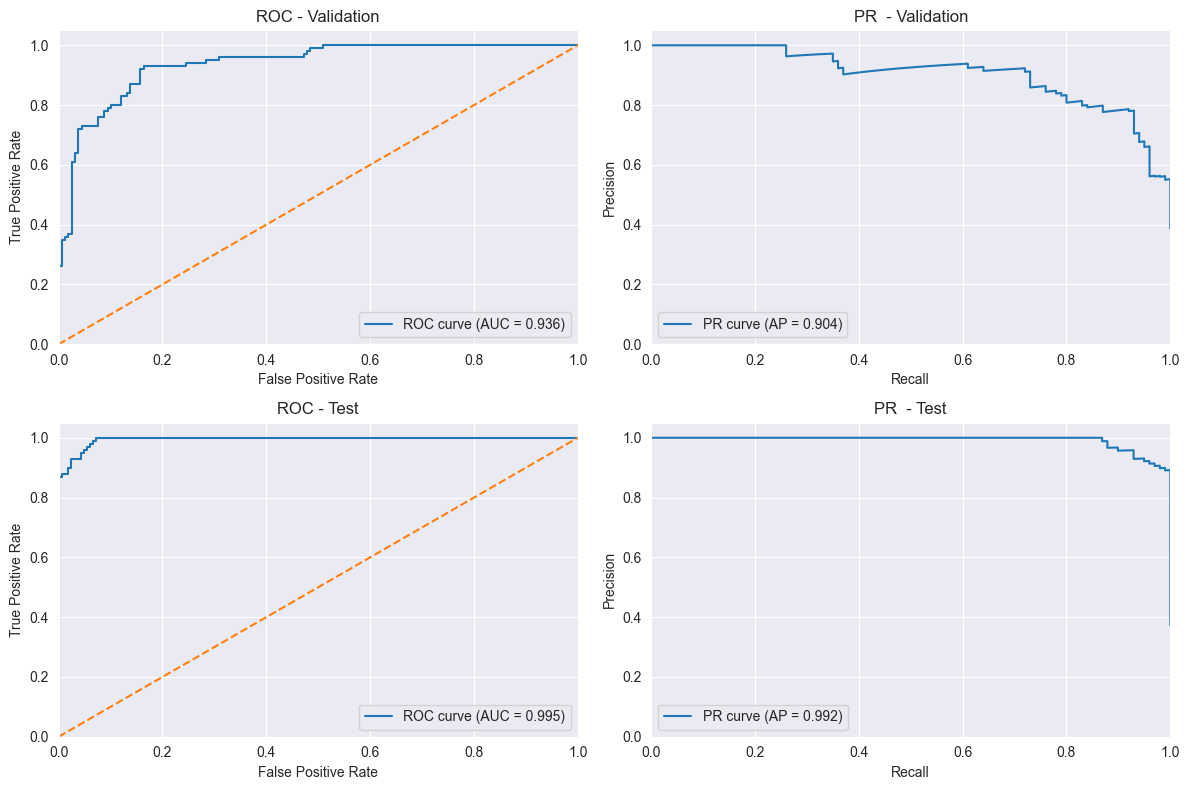

{'aggr': 'mean', 'disable_mp': False, 'dropout': 0.1, 'enable_all_rev': False, 'hidden_dimensions': [128, 64, 32], 'lr': 0.0003, 'num_layers': 1, 'weight_decay': 0.0}


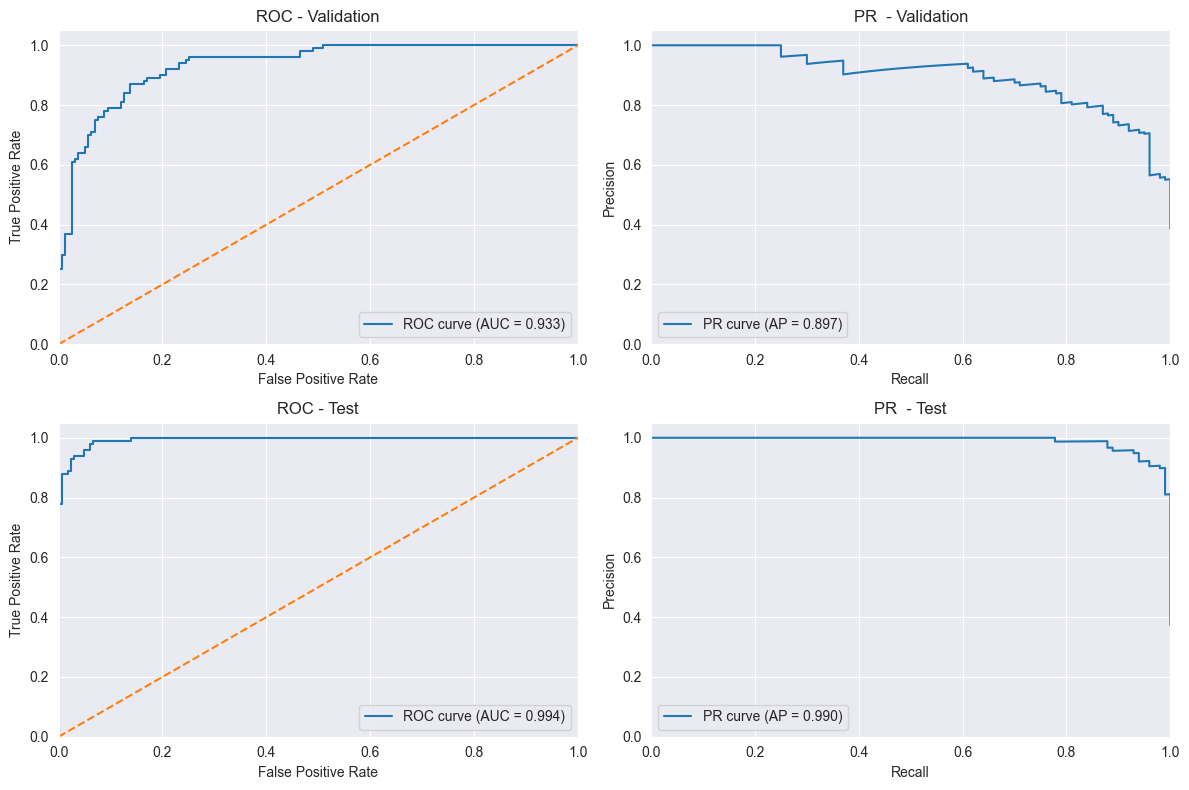

{'aggr': 'mean', 'disable_mp': False, 'dropout': 0.0, 'enable_all_rev': False, 'hidden_dimensions': [128, 64, 32], 'lr': 0.0003, 'num_layers': 1, 'weight_decay': 1e-05}


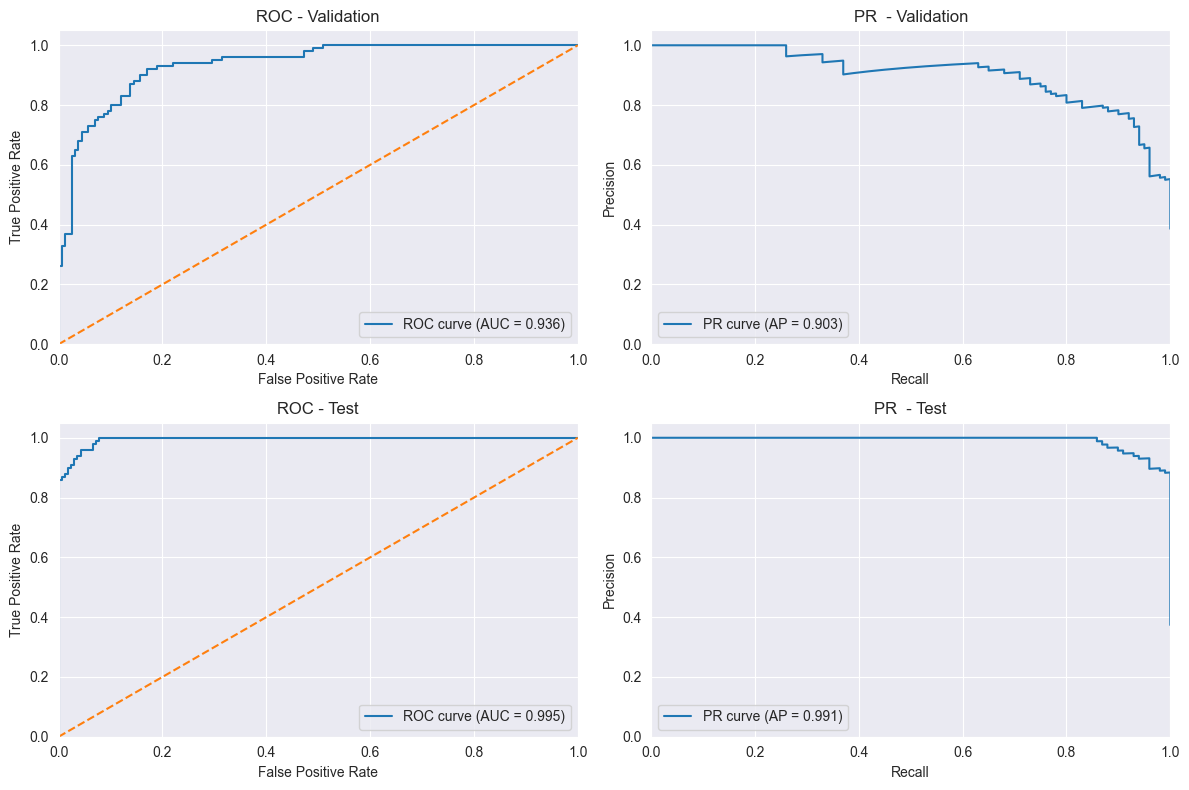

In [56]:
for res in final_runs:
    print(res["cfg"])
    y_true_val = res["summary"]["y_true_val"]
    y_score_val = res["summary"]["y_score_val"]

    y_true_test = res["summary"]["y_true_test"]
    y_score_test = res["summary"]["y_score_test"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Zeile 1: Validation
    plot_roc(axes[0, 0], y_true_val,  y_score_val,  title="ROC - Validation")
    plot_pr(axes[0, 1], y_true_val,  y_score_val,  title="PR  - Validation")

    # Zeile 2: Test
    plot_roc(axes[1, 0], y_true_test, y_score_test, title="ROC - Test")
    plot_pr(axes[1, 1], y_true_test, y_score_test, title="PR  - Test")

    plt.tight_layout()
    plt.show()

In [10]:
best_settings = torch.load("GNN_1")

In [11]:
print(best_settings)

{'model_state_dict': OrderedDict({'lin_init.outpoint.weight': tensor([[ 0.2355,  0.1460,  0.3689,  ..., -0.2177,  0.4203, -0.2401],
        [ 0.0797,  0.2101, -0.0773,  ..., -0.1392,  0.3091, -0.1045],
        [-0.1355,  0.3304,  0.3310,  ..., -0.1882,  0.0284,  0.0193],
        ...,
        [ 0.0116, -0.1312,  0.3023,  ..., -0.3173,  0.2828, -0.3690],
        [-0.3001, -0.0880, -0.2748,  ..., -0.2963, -0.1889,  0.4237],
        [ 0.0563,  0.1894, -0.1612,  ...,  0.1718,  0.3222,  0.0733]]), 'lin_init.outpoint.bias': tensor([ 0.3543, -0.2213, -0.1891, -0.3335, -0.1794, -0.1211,  0.2026, -0.0245,
         0.3175, -0.1981, -0.0512,  0.3715, -0.0780,  0.2520,  0.3672, -0.3246,
         0.2418,  0.2888, -0.1002, -0.3274, -0.2612, -0.2304,  0.1211,  0.0352,
         0.0864,  0.0587, -0.0425, -0.0426, -0.1169, -0.2378,  0.2820,  0.2355,
         0.2200, -0.1047,  0.1262, -0.2759,  0.0545, -0.1433, -0.2639,  0.2203,
         0.0498,  0.2866,  0.1248, -0.0477, -0.3376,  0.0968, -0.1217, -0.304

In [27]:
in_dims = infer_in_channels_dict(train_split[0])

loaded_model = HeteroGNN(
        in_dims,
        hidden1=best_settings['cfg']["hidden_dimensions"][0],
        hidden2=best_settings['cfg']["hidden_dimensions"][1],
        hidden3=best_settings['cfg']["hidden_dimensions"][2],
        dropout=best_settings['cfg']["dropout"],
        disable_mp=best_settings['cfg']["disable_mp"],
        enable_all_rev=best_settings['cfg']["enable_all_rev"],
        num_layers=best_settings['cfg']["num_layers"],
        aggr=best_settings['cfg']["aggr"]
    ).to(DEVICE)

loaded_model.load_state_dict(best_settings['model_state_dict'])
loaded_model.eval()

HeteroGNN(
  (lin_init): ModuleDict(
    (outpoint): Linear(in_features=8, out_features=128, bias=True)
    (tx): Linear(in_features=28, out_features=128, bias=True)
  )
  (convs): ModuleList(
    (0): HeteroConv(num_relations=4)
  )
  (bns): ModuleList(
    (0): ModuleDict(
      (outpoint): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (tx): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (res): ModuleList(
    (0): ModuleDict(
      (outpoint): Identity()
      (tx): Identity()
    )
  )
  (mlp_head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
  (mlp_tower): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4)

In [51]:
eval_bs = 16
eval_dataset = train_split + val_split + test_split
loader = DataLoader(eval_dataset, batch_size=eval_bs, shuffle=False)

# eval_epoch_pairwise kommt aus deinem bestehenden Code
loss, metrics, y_true, y_score = eval_epoch_pairwise(
    loaded_model,
    loader,
    DEVICE,
    log_first_batch=False,
    collect_scores=True
)

print(f"Eval loss: {loss:.4f}")
print("Eval metrics:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

print("Evaluation results:")
print(f"loss: {loss}, metrics: {metrics}, y_true: {y_true}, y_score: {y_score}")

Eval loss: 2.2000
Eval metrics:
  acc_graph: 0.4220
  acc_node: 0.4220
  f1: 0.4220
  prec: 0.4220
  rec: 0.4220
  roc_auc: 0.2928
  pr_auc: 0.4134
Evaluation results:
loss: 2.2000342460632325, metrics: {'acc_graph': 0.422, 'acc_node': 0.422, 'f1': 0.422, 'prec': 0.422, 'rec': 0.422, 'roc_auc': 0.29275, 'pr_auc': 0.41342860869475223}, y_true: [0. 1. 0. ... 1. 0. 1.], y_score: [0.02665052 0.97334945 0.03676345 ... 0.9408779  0.07211249 0.9278875 ]


{'aggr': 'mean', 'disable_mp': False, 'dropout': 0.0, 'enable_all_rev': False, 'hidden_dimensions': [128, 64, 32], 'lr': 0.0003, 'num_layers': 1, 'weight_decay': 0.0}


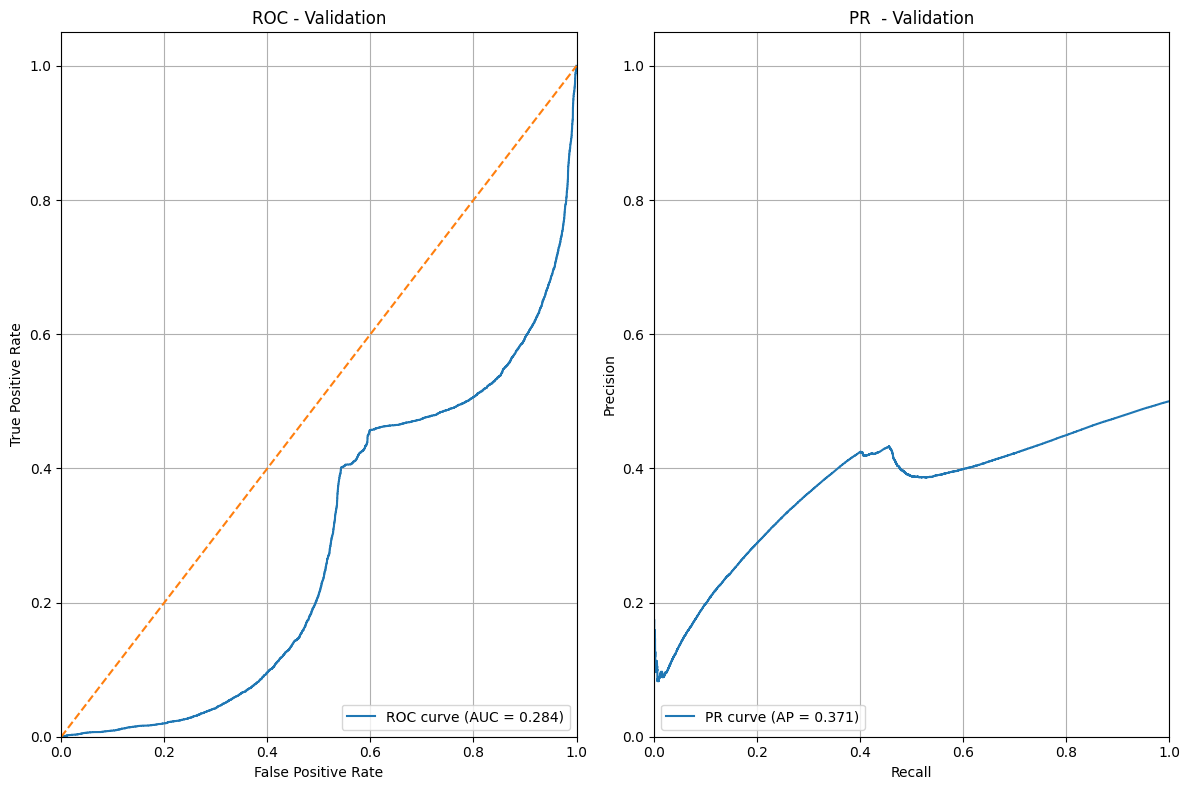

In [58]:
print(best_settings["cfg"])

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Zeile 1: Validation
plot_roc(axes[0], y_true,  y_score,  title="ROC - Validation")
plot_pr(axes[1], y_true,  y_score,  title="PR  - Validation")

plt.tight_layout()
plt.show()
